In [27]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


In [1]:
height = 512
width = 400

content_image_path = 'content photo path'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image


NameError: name 'Image' is not defined

In [2]:
style_image_path = 'style photo path'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image


NameError: name 'Image' is not defined

In [30]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
# Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
# Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
style_array = style_array[:, :, :, ::-1]



(1, 512, 400, 3)
(1, 512, 400, 3)


In [46]:
content_image_var = backend.variable(content_array)
style_image_var = backend.variable(style_array)
combination_image_var = backend.placeholder((1, height, width, 3))


In [47]:
combination_image_var

<tf.Tensor 'Placeholder_54:0' shape=(1, 512, 400, 3) dtype=float32>

In [48]:
input_tensor = backend.concatenate([content_image_var, style_image_var, combination_image_var], axis=0)


In [49]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)


In [50]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers


{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 512, 400, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 512, 400, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 512, 400, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 256, 200, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 256, 200, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 256, 200, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 128, 100, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 128, 100, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 128, 100, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 128, 100, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 64, 50, 256) dtype=float32

In [64]:
content_weight = 0.025
style_weight = 0.025
total_variation_weight = 1.0


In [70]:
loss = backend.variable(0.)


In [84]:
def content_loss(layers, layer_name, content_weight = 0.025):
    layer = layers[layer_name]
    content_image_features = layer[0, :, :, :]
    combination_features = layer[2, :, :, :]
    return backend.sum(backend.square(combination_features - content_image_features))

closs = content_loss(layers, 'block2_conv2')

print(closs)


Tensor("Sum_37:0", shape=(), dtype=float32)


In [89]:
def gram_matrix(x):
    print(x)
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    print(features)
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss_single_layer(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def style_loss(layers, feature_layers, style_weight=0.025 ):
    loss = backend.variable(0.)
    for layer_name in feature_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        sl = style_loss_single_layer(style_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
    return loss

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

sloss = style_loss(layers, feature_layers)


Tensor("strided_slice_206:0", shape=(512, 400, 64), dtype=float32)
Tensor("Reshape_90:0", shape=(64, 204800), dtype=float32)
Tensor("strided_slice_207:0", shape=(512, 400, 64), dtype=float32)
Tensor("Reshape_91:0", shape=(64, 204800), dtype=float32)
Tensor("strided_slice_210:0", shape=(256, 200, 128), dtype=float32)
Tensor("Reshape_92:0", shape=(128, 51200), dtype=float32)
Tensor("strided_slice_211:0", shape=(256, 200, 128), dtype=float32)
Tensor("Reshape_93:0", shape=(128, 51200), dtype=float32)
Tensor("strided_slice_214:0", shape=(128, 100, 256), dtype=float32)
Tensor("Reshape_94:0", shape=(256, 12800), dtype=float32)
Tensor("strided_slice_215:0", shape=(128, 100, 256), dtype=float32)
Tensor("Reshape_95:0", shape=(256, 12800), dtype=float32)
Tensor("strided_slice_218:0", shape=(64, 50, 512), dtype=float32)
Tensor("Reshape_96:0", shape=(512, 3200), dtype=float32)
Tensor("strided_slice_219:0", shape=(64, 50, 512), dtype=float32)
Tensor("Reshape_97:0", shape=(512, 3200), dtype=float32)


In [81]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image_var)


In [90]:
loss = sloss
grads = backend.gradients(loss, combination_image_var)


In [91]:
grads

[<tf.Tensor 'gradients_3/concat_2_grad/Slice_2:0' shape=(1, 512, 400, 3) dtype=float32>]

In [92]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image_var], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


In [93]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 1.3958547e+20
Iteration 0 completed in 12s
Start of iteration 1
Current loss value: 3.078689e+19
Iteration 1 completed in 12s
Start of iteration 2
Current loss value: 1.5098571e+19
Iteration 2 completed in 12s
Start of iteration 3
Current loss value: 9.463848e+18
Iteration 3 completed in 12s
Start of iteration 4
Current loss value: 6.487381e+18
Iteration 4 completed in 12s
Start of iteration 5
Current loss value: 4.2490808e+18
Iteration 5 completed in 12s
Start of iteration 6
Current loss value: 2.7666733e+18
Iteration 6 completed in 12s
Start of iteration 7
Current loss value: 1.9518804e+18
Iteration 7 completed in 12s
Start of iteration 8
Current loss value: 1.3928692e+18
Iteration 8 completed in 12s
Start of iteration 9
Current loss value: 1.031974e+18
Iteration 9 completed in 12s


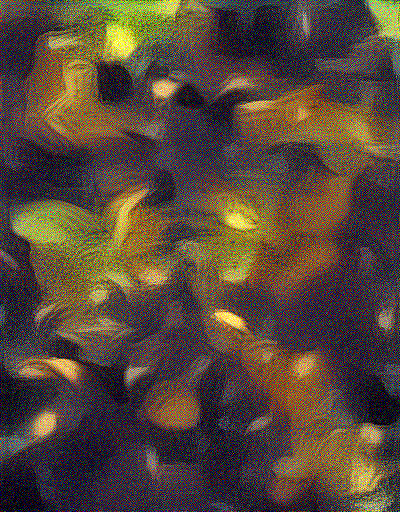

In [94]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)
